# Appendix 2 - Code

In [1]:
# Modules:
from PIL import Image


import os
import os.path
import sys
import shutil
from pprint import pprint
from datetime import datetime

from parflowio.pyParflowio import PFData
from parflow import Run

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import numpy as np
import numpy.ma as ma
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.path import Path
from matplotlib.patches import PathPatch

from copy import copy
from copy import deepcopy

# import pfspinup
# see more: https://grapp1parflow.readthedocs.io/en/latest/python/getting_started.html
from parflowio.pyParflowio import PFData # for reading / writing PFB files

# for DL
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset # for refactoring x and y
from torch.utils.data import DataLoader # for batch submission

from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from pfread_manual import pfread
from lstm_models import sliding_windows
from lstm_models import LSTM


# for metrics
from sklearn.metrics import mean_squared_error
from utils import compute_stats


# Path to the SandTank Repo
dev_path = '/home/SHARED/ML_TV/HydroGEN/modules/'
#Add Sand Tank path to the sys path
sys.path.append(dev_path)
from transform import float32_clamp_scaling

## Post Processing Forcing Figures
Some important notes

*Updated 04/24/2021*

For files of name type `/UCRB_DSWR.1983.pfb`

You will see they are shape `out_data.shape` = `(5, 3, 366)`

Where `out_data.shape[0] = 5` -> number of stations in the dataset of this order `[9110000, 9329050, 9196500, 9107000, 9210500]`

Where `out_data.shape[1] = 3` -> scaler outputs of dynamic variables `0 = mean, 1 = std over tim, 2 = std over space`


Where `out_data.shape[2] = 366` -> number of days in a year (where the last is an extra just for leap years that is normally zero)

The below is taken from `scripts/UCRB_figs.ipynb`

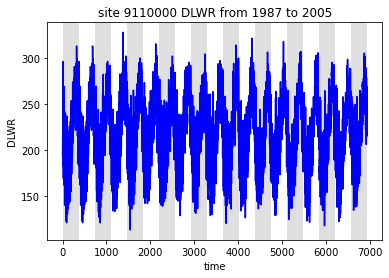

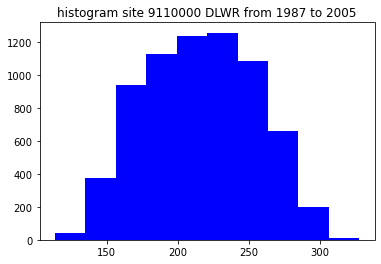

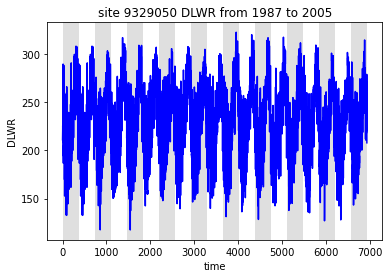

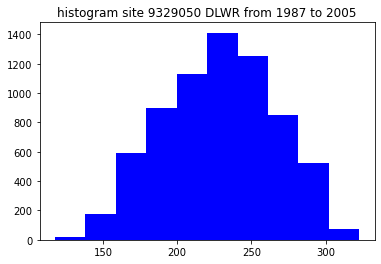

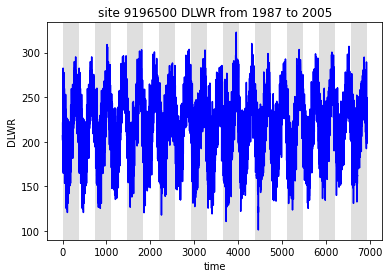

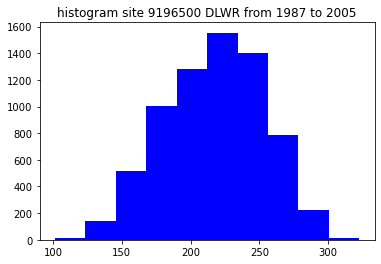

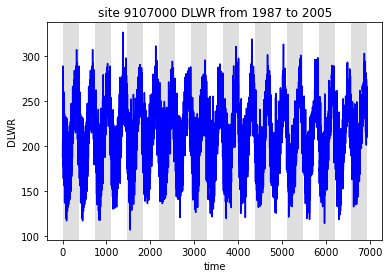

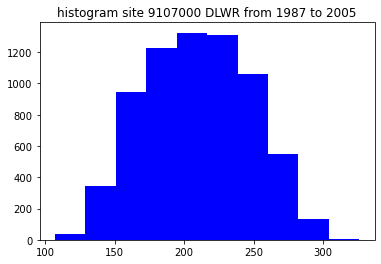

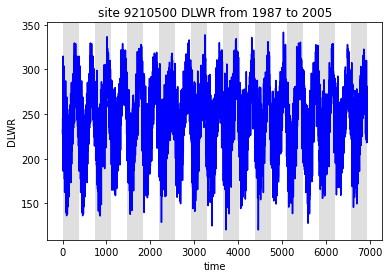

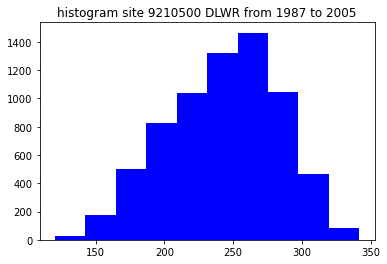

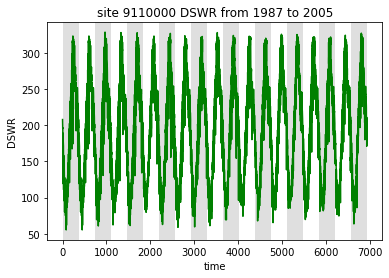

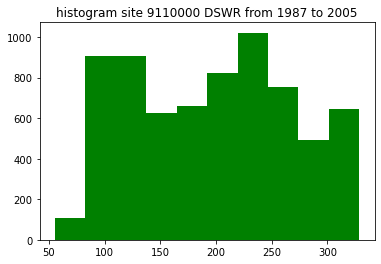

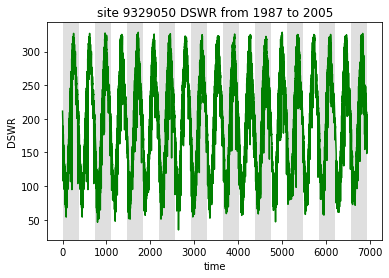

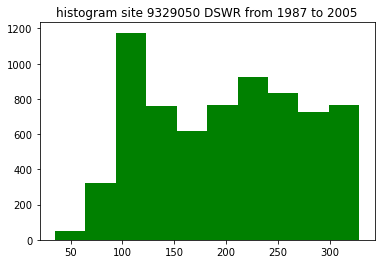

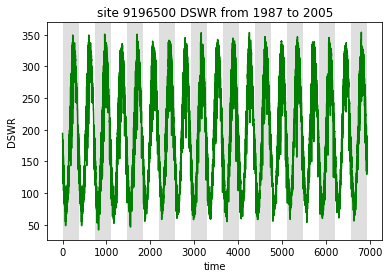

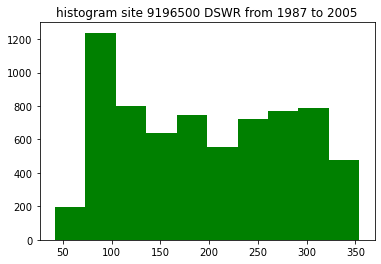

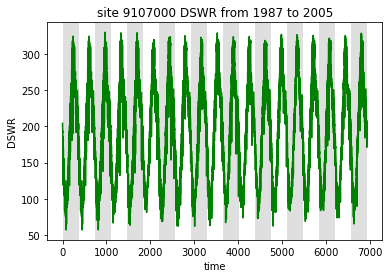

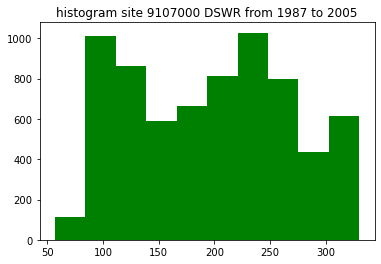

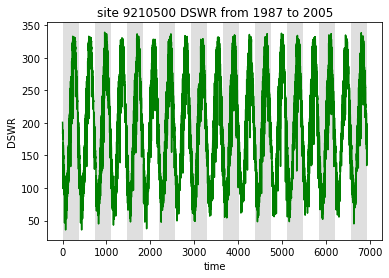

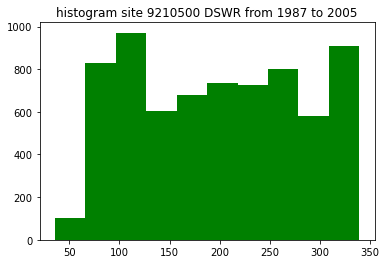

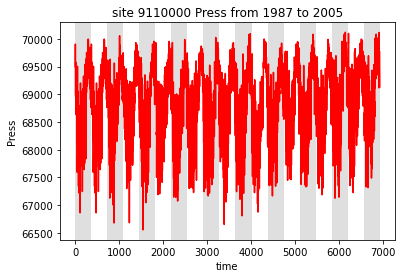

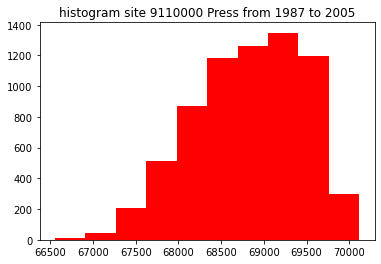

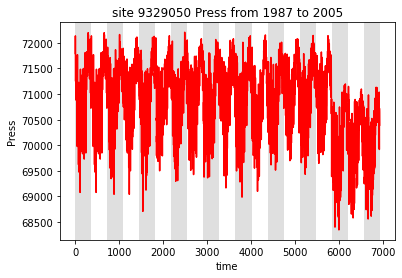

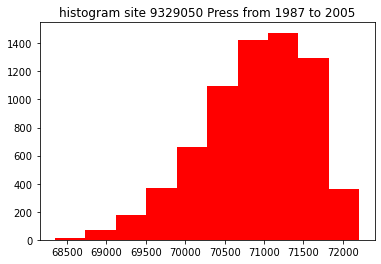

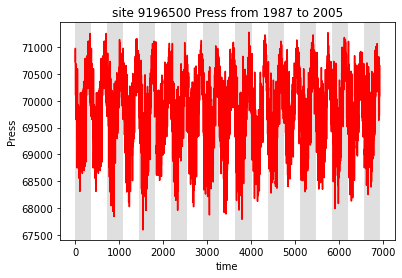

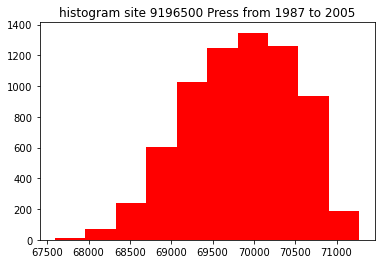

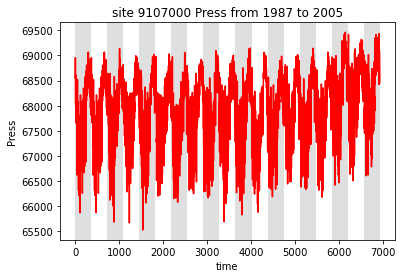

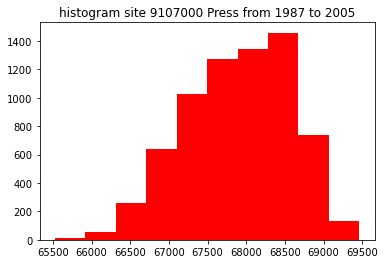

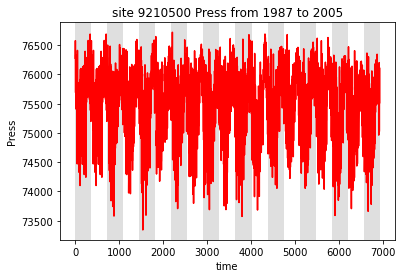

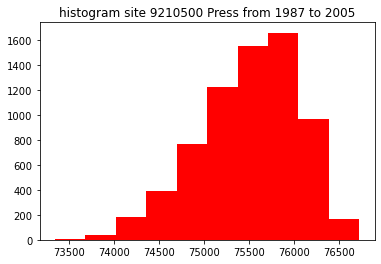

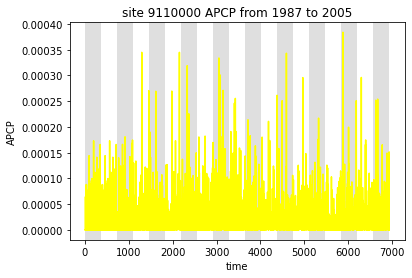

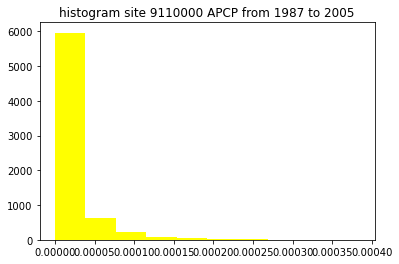

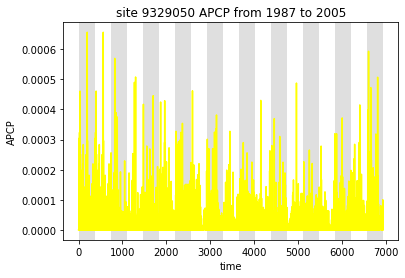

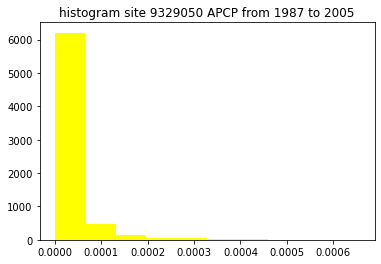

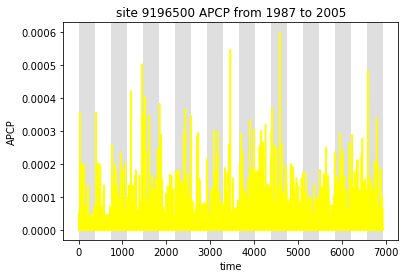

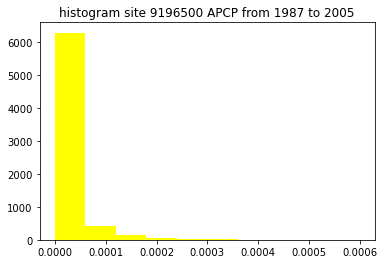

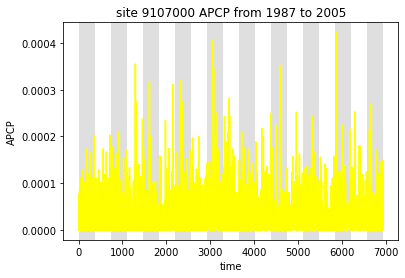

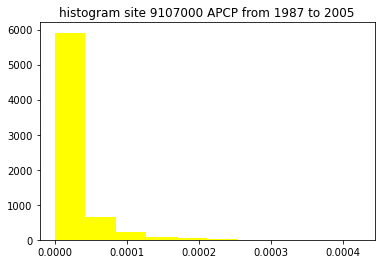

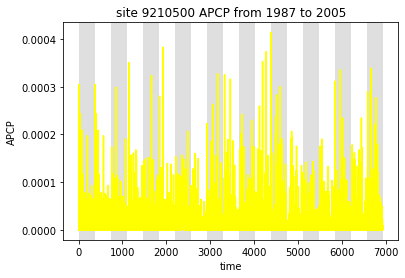

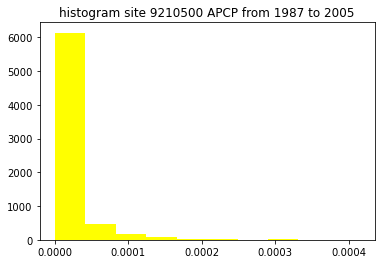

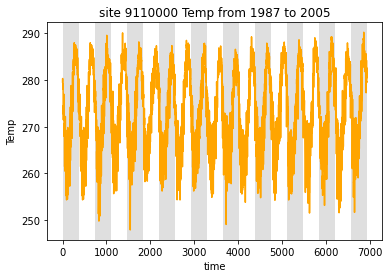

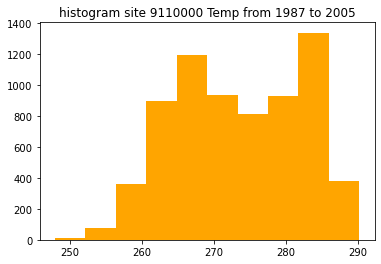

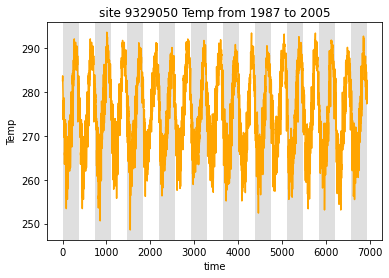

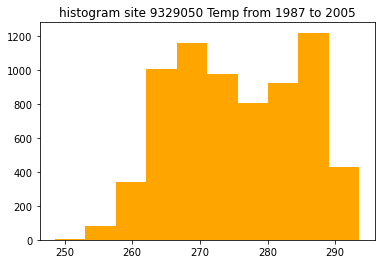

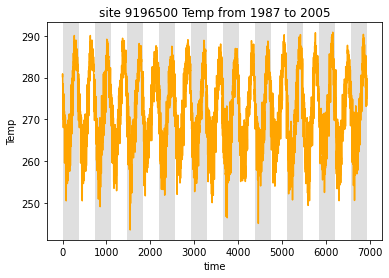

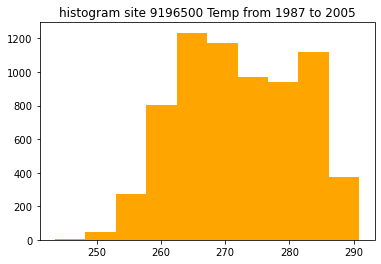

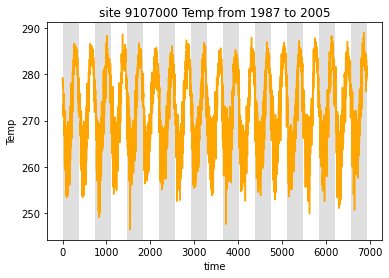

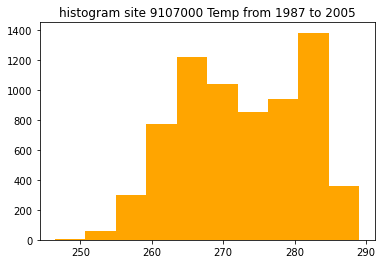

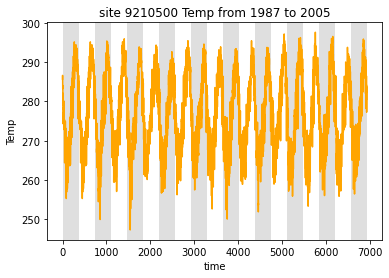

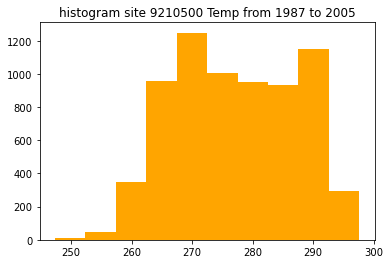

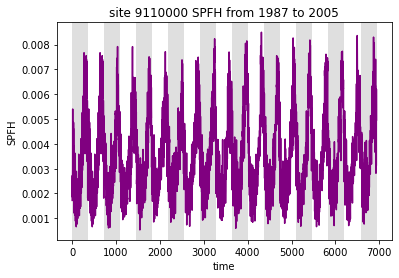

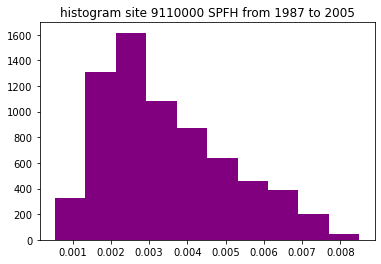

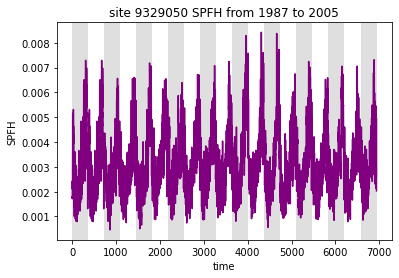

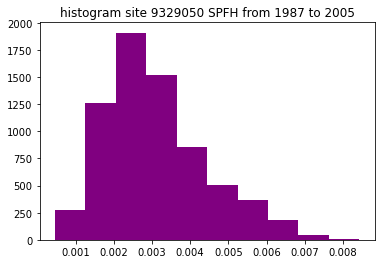

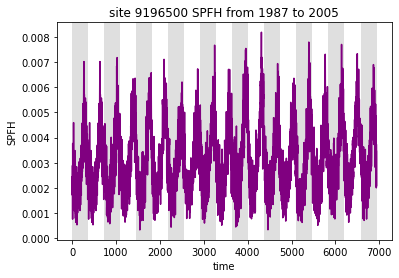

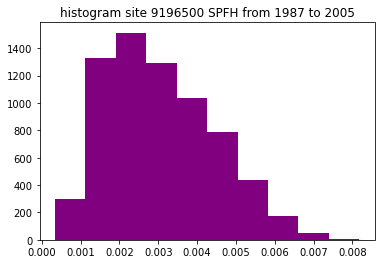

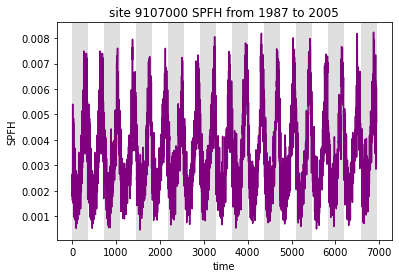

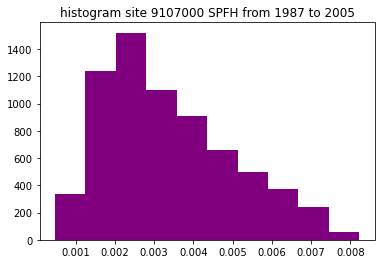

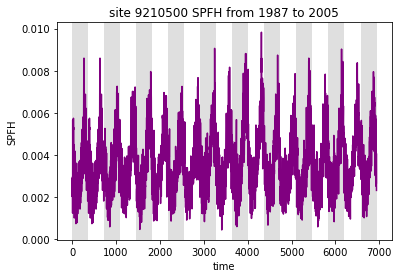

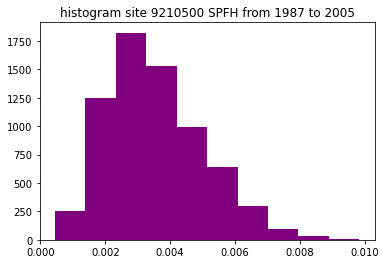

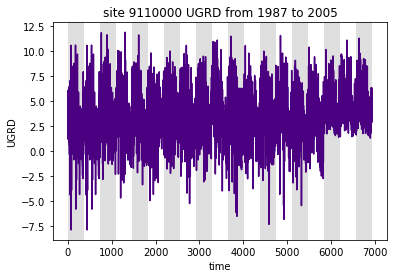

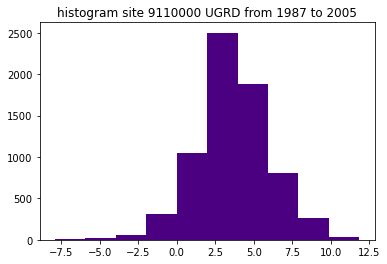

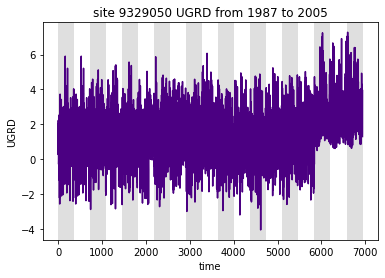

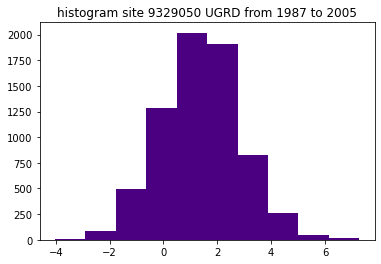

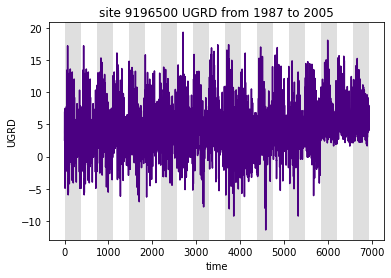

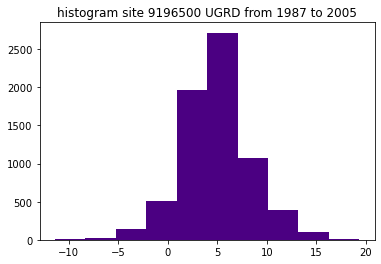

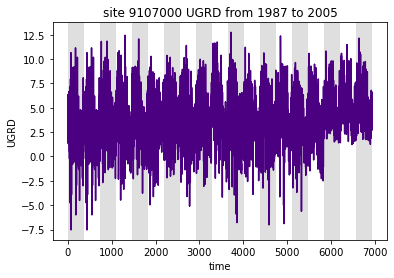

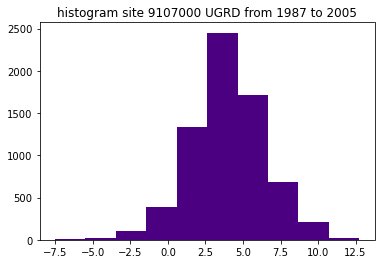

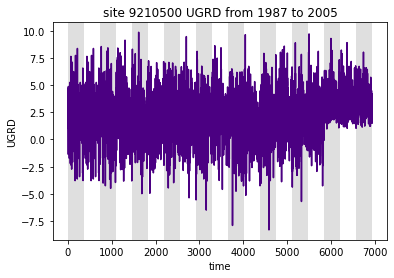

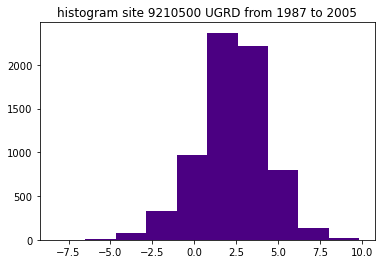

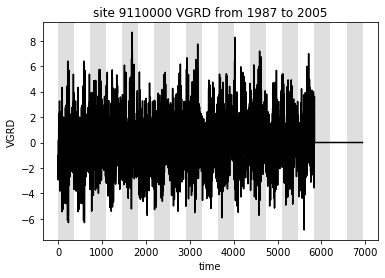

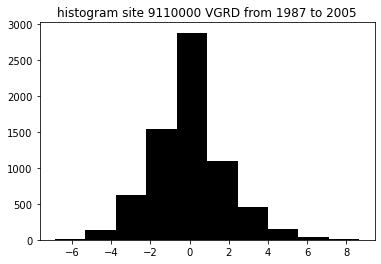

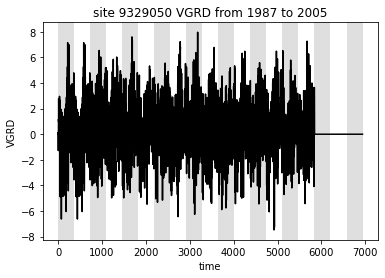

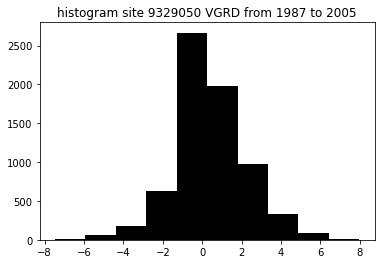

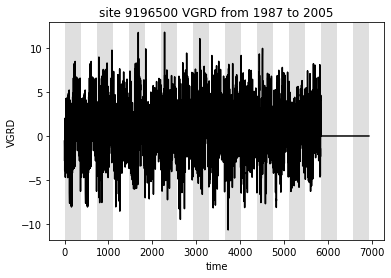

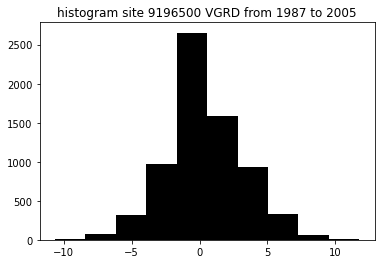

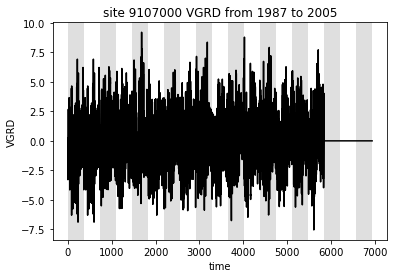

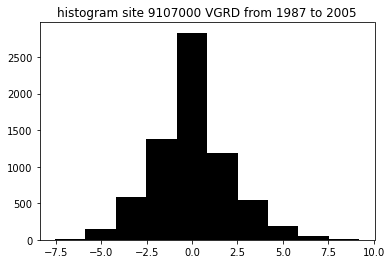

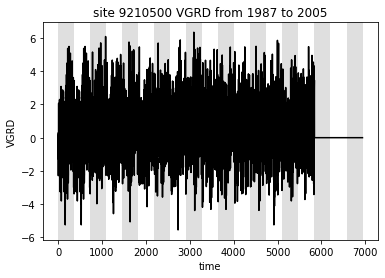

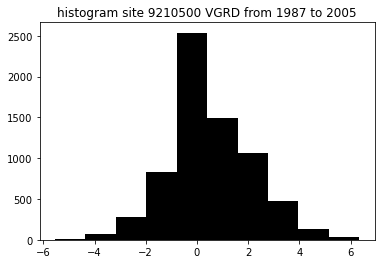

In [2]:
# Setup array of years
path = '../data_out'

huc_name_list = [9110000, 9329050, 9196500, 9107000, 9210500]
labelist = ['DLWR', 'DSWR', 'Press', 'APCP', 'Temp', 'SPFH', 'UGRD', 'VGRD']
collist = ['blue','green','red', 'yellow', 'orange', 'purple', 'indigo','black']
YEARS = []
for yr in range(1987,2006): # QH 1983, 2020 for all years
    YEARS.append(yr)

# #GLOBALS#
# -----
# change for exporting 
exp_name = 'ML_FinalProj_1987-2007'
save = False

# keep track of params
j = 0

# for plotting
# add std
bracket = False
std = 0
# data, # 0 = average, 1 = std space, 2 = std time
data = 0

# Aggregate values between plots # update - assume that we use the dates by water year
agg = True
# set instance of first day (assume Oct 1, YYYY[0]-1)
y0 = YEARS[0]-1
day0 = 1
mon0 = 10
date0 = str(mon0)+'/'+str(day0)+'/'+str(y0)
# date used for resampling
date1 = '1/1/'+str(YEARS[0])
df_l = [] # list of data frames



# #LOOPING#
# -----



for label in labelist:
    # assemble data
    for yr in YEARS: 
        # pull out data test
#         print(path+'/UCRB_'+label+'.'+str(yr)+'.pfb')
        out = PFData(path+'/UCRB_'+label+'.'+str(yr)+'.pfb')
        out.loadHeader()
        out.loadData()
        out_data = out.getDataAsArray()
        # get ride of random zeros in last row
        out_data = out_data[:,:,:-1]

        # create array of placeholder values
        if yr == YEARS[0]:
            label_arr = out_data
        else:
            label_arr = np.concatenate([label_arr,out_data], axis=2)
#             print(label_arr.shape)
    
    # Plot stuff
    # for each gage
    for ea in range(label_arr.shape[0]):
#         print(huc_name_list[ea])
        # for each parameter
        fig, ax = plt.subplots()
        # for indexing colorlist
        j = labelist.index(label)
        # time, data, color
        ax.plot(range(label_arr.shape[2]), label_arr[ea,data, :], collist[j])
        if bracket:
            ax.plot(range(label_arr.shape[2]), label_arr[ea,data, :]+label_arr[ea,std, :], collist[j], linestyle=':')
            ax.plot(range(label_arr.shape[2]), label_arr[ea,data, :]-label_arr[ea,std, :], collist[j], linestyle=':')
        ax.set_xlabel('time')
        ax.set_ylabel(label)
        plt.title(str('site '+str(huc_name_list[ea])+' '+label+' from '+str(YEARS[0])+' to '+str(YEARS[-1])))
        for i in range(0,len(YEARS),2):
            day = i*365
            plt.axvspan(day,day+365, facecolor='grey', alpha=0.25)
        if save and (huc_name_list[ea] == 9110000):
            plt.savefig(path+'/2_fig/fig'+label+exp_name+str(huc_name_list[ea])+'.png')
        plt.show()
        
        plt.hist(label_arr[ea,data, :], color=collist[j])
        plt.title(str('histogram site '+str(huc_name_list[ea])+' '+label+' from '+str(YEARS[0])+' to '+str(YEARS[-1])))
        if save and (huc_name_list[ea] == 9110000):
            plt.savefig(path+'/2_fig/fig_hist'+label+exp_name+str(huc_name_list[ea])+'.png')
        plt.show()
        
        # if aggregate
        if agg:
            if j == 0:
                df_l.append(pd.DataFrame())
            df = df_l[ea]
            df[label] = label_arr[0,data,:]
            # set up date indexes
            df['deltatime'] = pd.to_timedelta(df.index, unit='D')
            df['timestamp'] = pd.Timestamp(date0) + df['deltatime']
            df['resampstamp'] = pd.Timestamp(date1) + df['deltatime']
            
            
        


### Read in (real) StreamFlow

In [3]:
path_st = '../streamflow_in/0'

df_st_l = []
for idx in range(len(huc_name_list)): # through all sites
    site = huc_name_list[idx]
    df_st = pd.read_csv(path_st+str(site)+'.csv')
    df_st['date'] = pd.to_datetime(df_st['date'])
    df_st.rename(columns={'date': 'timestamp', 'flow': 'Flow_Real'}, inplace=True)
#     df_st.info()
    df_st_l.append(df_st)
    del df_st, site
    


### Read in static variable

In [4]:
path_static = '../data_out'

static_col_list = ['clm.drainagearea','clm.out.perm_x','clm.out.porsity','clm.out.slope_x','clm.out.slope_y']

df_station_l = []
for site in huc_name_list: # loop through all sites
    df_static = np.zeros((2,len(static_col_list))) # for each site (indicator (x2), parameter (x5))
    it = 0
    for static in static_col_list:
        out = PFData(path_static+'/'+str(site)+'_'+static+'.pfb')
#         print(path_static+'/'+str(site)+'_'+static+'.pfb')
        out.loadHeader()
        out.loadData()
        out_data = out.getDataAsArray()
        
        try:
#             print(out_data.shape)

            # set input average forcing
            df_static[0, it] = out_data.mean()
            # set standard dev in axis 1,2 (over time)
            df_static[1, it] = np.std(out_data)
        except:
            pass
        it = it + 1
        
    df_station_l.append(df_static)
        

### Merge together datasets

In [5]:
# merge together each dataset on a left join
for idx in range(len(huc_name_list)):
    site = huc_name_list[idx]
#     print(idx)
    df_l[idx] = pd.merge(df_l[idx], df_st_l[idx], how='left', on='timestamp')
    del site
#     it = 0
#     for static in static_col_list:
#         df_l[idx][static] = df_station_l[idx][0,it]
#         df_l[idx][static+'std'] = df_station_l[idx][1,it]

### Summarize and transform temporal data

In [6]:
# add flow
labelist.append('Flow_Real')
# for ea in static_col_list:
#     labelist.append(ea)
#     labelist.append(ea+'std')
min_label_list = []
max_label_list = []

i = 0
# loop through all forcings
for elem in labelist:
    min_label_list.append(1000000)
    max_label_list.append(-1000000)
    
    # loop through all stations in this dataset
    for df in df_l:
        # set minimum for element in station dataset
        min_local = df[elem].min()
        max_local = df[elem].max()
        
        # set global minimum/maximum if it is the minimum/maximum overall
        if min_local < min_label_list[i]:
            min_label_list[i] = min_local
        if max_local > max_label_list[i]:
            max_label_list[i] = max_local
        
        del min_local, max_local
    
    # iterate
    i = i+1
    
# review work:
print(labelist)
print(min_label_list)
print(max_label_list)
        

# scaled data
df_l_scaled = deepcopy(df_l)

# scale the data and save for later
scale_l = [] # this allows for un-transforming the data
j = 0 # iterate to move through the min max lists
for elem in labelist:
    # create transform and save
    transf = float32_clamp_scaling(src_range=[min_label_list[j],max_label_list[j]], dst_range=[0, 1])
    scale_l.append(transf)
    
    # do transform in place
    for df in df_l_scaled:
        df_2_scale = df[elem].to_numpy() 
        df[elem] = transf(df_2_scale)
#         print('success')
    del transf
    j = j + 1
    



['DLWR', 'DSWR', 'Press', 'APCP', 'Temp', 'SPFH', 'UGRD', 'VGRD', 'Flow_Real']
[113.56473291607196, 55.378321229241664, 66552.2907803778, 0.0, 247.9040759297759, 0.0005314474740379672, -7.906057086946189, -6.868398970356629, 2.5]
[327.7075340407556, 328.68986619784863, 70118.24749962668, 0.0003839677328703982, 290.2426188778539, 0.008497508457841231, 11.852656420342722, 8.664247304030784, 2480.0]


### Summary Statistics (normalized from 0 to 1) for each flow site

In [11]:
# make an object containing the top 10 and bottom 10% flow for each site
# make an object containing the max and min of streamflow for each huc
# make an object printing out the 50th percentile
# shape -> [10%, 90%, min, max]
perc_10_arr = np.empty((4, len(huc_name_list)))
for ea in range(len(huc_name_list)):
    huc_name = huc_name_list[ea]
    print(huc_name)
    print('min ', df_l_scaled[ea]['Flow_Real'].min())
    print('10% exceedance ', df_l_scaled[ea]['Flow_Real'].quantile([0.1, 0.9]).iloc[0])
    print('50% percentile ', df_l_scaled[ea]['Flow_Real'].quantile(0.5))
    print('90% exceedance ', df_l_scaled[ea]['Flow_Real'].quantile([0.1, 0.9]).iloc[1])
    print('max ', df_l_scaled[ea]['Flow_Real'].max(), '\n')
    perc_10_arr[0, ea] = df_l_scaled[ea]['Flow_Real'].quantile([0.1, 0.9]).iloc[0]
    perc_10_arr[1, ea] = df_l_scaled[ea]['Flow_Real'].quantile([0.1, 0.9]).iloc[1]
    perc_10_arr[2, ea] = df_l_scaled[ea]['Flow_Real'].min()
    perc_10_arr[3, ea] = df_l_scaled[ea]['Flow_Real'].max()
    
print(perc_10_arr)



9110000
min  0.02538849646821393
10% exceedance  0.04419778002018163
50% percentile  0.07689202825428859
90% exceedance  0.225832492431887
max  1.0 

9329050
min  0.0
10% exceedance  0.0008879919273461151
50% percentile  0.0020988900100908175
90% exceedance  0.008678102926337033
max  0.08415741675075682 

9196500
min  0.0019374369323915236
10% exceedance  0.004238143289606458
50% percentile  0.015136226034308779
90% exceedance  0.2012108980827447
max  0.9233097880928355 

9107000
min  0.006659939455095863
10% exceedance  0.011907164480322906
50% percentile  0.019979818365287588
90% exceedance  0.10393541876892029
max  0.4510595358224016 

9210500
min  0.0012512613521695256
10% exceedance  0.0062563067608476285
50% percentile  0.011099899091826439
90% exceedance  0.05146316851664985
max  0.28678102926337035 

[[4.41977800e-02 8.87991927e-04 4.23814329e-03 1.19071645e-02
  6.25630676e-03]
 [2.25832492e-01 8.67810293e-03 2.01210898e-01 1.03935419e-01
  5.14631685e-02]
 [2.53884965e-02 0.0

### Histogram of Flow Distribution

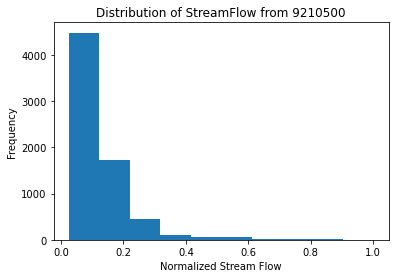

In [8]:
# investigate the distribution of streamflow 
plt.hist(df_l_scaled[0]['Flow_Real'])
plt.xlabel('Normalized Stream Flow')
plt.ylabel('Frequency')
plt.title('Distribution of StreamFlow from '+str(huc_name))
plt.show()

## Globals

In [50]:
# data source

path = '../0507_grande'
          
save = False

if save:
    try:
        os.mkdir(path)
    except:
        print('warning: file exists')
        pass

huc_index = 4 # for choosing which huc to train on
    
data = copy(df_l_scaled[huc_index])

# note shape is important because LSTM expects three dimensions
# data = .reshape(-1, 1)

# sliding sequence length (by default, the same as windows set in globals for previous step)
seq_length = 14 # window
# prediction
fut_length = 7 # when prediction

# batch size
bs = 100

# fraction of data to include in training set (1=all,0=none, remainder in test set)
test_frac = 0.2

# For LSTM
num_epochs = 500 # number of times iterating through the model
learning_rate = 0.001 # rate of learning

input_size = 9 # nodes on the input (should be number of features)
hidden_size = 10 # number of nodes in hidden layer 
num_layers = 1 # number of hidden layers

num_classes = 1 # nodes in output (should be 1)


if save:
    print('saving')
    file = open(path+"/params.txt", "w")
    file.write(f'Run Datetime {datetime.now()}\n')
    file.write(f'Sample Date Range {YEARS[0]} to {YEARS[-1]}\n')
    file.write(f'Huc index: {huc_index}\n')
    file.write(f'Huc Name: {huc_name_list[huc_index]}\n')
    file.write(f'Sequence Length {seq_length}\n')
    file.write(f'Prediction Length {fut_length}\n')
    file.write(f'test fraction {test_frac}\n')
    file.write(f'LSTM Params: Number of epochs - {num_epochs}\n')
    file.write(f'LSTM Params: learning rate - {learning_rate}\n')
    file.write(f'LSTM Params: input_size = {input_size}\n')
    file.write(f'LSTM Params: hidden_size = {hidden_size}\n')
    file.write(f'LSTM Params: num_layers = {num_layers}\n')
    file.write(f'LSTM Params: num_classes = {num_classes}\n')
    file.close()

## Import Data
* This is the first step of the PyTorch procedure
* Sets training data equal to normalized flow data
* Uses the function sliding_windows to define the set of training and test data
* Sets variables as Torch Tensors

In [51]:
def delnull(x_in, y_in):
    '''
    This sub for removing columns with null values
    in_x -> input x array from the sliding_windows procecure)
    in_y -> input y array from the sliding windows procedure)
    '''
    
    # keep track of dimensions
    num_x_axes = len(x_in.shape)
    if num_x_axes > 1:
        axes_tup = []
        for shp in range(1,num_x_axes,1):
            axes_tup.append(shp)
        axes_tup = tuple(axes_tup)
    else:
        axes_tup = 0    
#     print(axes_tup)

    # figure out null values
    y_boolean = np.isnan(y_in)
    x_isnan = np.sum(np.isnan(x_in),(1,2))
    x_boolean = np.zeros(x_isnan.shape)
    x_boolean[x_isnan > 0] = 1
    x_boolean = np.array(x_boolean, dtype=bool)
    
#     print(x.shape)
#     print(x_boolean.shape)
#     print(y.shape)
    
    # convert all booleans
    all_boolean = np.zeros(y_boolean.shape)
    all_boolean[x_boolean | y_boolean] = 1
    all_boolean = np.array(all_boolean, dtype=bool)

    # drop y and x values
    x_del = np.delete(x_in, all_boolean, axis=(0))
    y_del = np.delete(y_in, all_boolean, axis=(0))
    
#     print(x_del.shape)
#     print(y_del.shape)
    
    return x_del, y_del, all_boolean



In [52]:
# 2. seperate train and test data, predictors and predicticands
# define sliding windows (note, these are defined in the globals) # x, y = sliding_windows(data[2], seq_length, fut_length)
# note - make sure target (in this case flow) is the last entry


# defaults of labelist ['DLWR', 'DSWR', 'Press', 'APCP', 'Temp', 'SPFH', 'UGRD', 'VGRD', 'Flow_Real']


# if we want to reset data to be just 1 dimension, subset the last column = 2
data = data
disc = str(labelist[:-1])+' -> '+str(labelist[-1])

it = 0
if len(labelist) > 1:
    for idx in labelist:
        x_0, y = sliding_windows(data[idx].to_numpy(), seq_length, fut_length)
        if idx == labelist[0]:
            x = np.zeros((x_0.shape[0],x_0.shape[1],len(labelist)))
#             print(x.shape)
#         print(x_0.shape)
        x[:,:,it] = x_0
        it = it+1
else:
    x, y = sliding_windows(data.to_numpy(), seq_length, fut_length)
    
# print(x[:,0,0])

# # reset x, if desired
# x = x[:,:,:-1]



# drop na values
x, y, t_bool = delnull(x, y)


if len(x.shape) < 3:
    x = np.expand_dims(x, axis=2)

# divide into test and train size, essentially into thirds
train_size = int(len(y) * test_frac)
test_size = len(y) - train_size

# note shape is important because LSTM expects three dimensions
# https://numpy.org/doc/stable/reference/generated/numpy.atleast_3d.html#numpy.atleast_3d
# https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html
# convert to torch tensors
dataX = Variable(torch.Tensor(x))
dataY = Variable(torch.Tensor(np.expand_dims(y, axis=1)))
print(dataX.shape)

# create train vars
trainX = Variable(torch.Tensor(x[0:train_size]))
trainY = Variable(torch.Tensor(np.expand_dims(y[0:train_size], axis=1)))
print(trainX.shape)

# playing with DataLoader and TensorDataset
train_ds = TensorDataset(trainX, trainY)
train_dl = DataLoader(train_ds, batch_size = bs)

# create test vars
testX = Variable(torch.Tensor(x[train_size:len(x)])) 
testY = Variable(torch.Tensor(np.expand_dims(y[train_size:len(y)],axis=1))) 
print(testX.shape)

if save:
    print('saving')
    file = open(path+"/inputs.txt", "w")
    file.write(f'Number of input features {input_size}\n')
    file.write('Input features are '+disc+'\n')
    file.close()


torch.Size([6914, 14, 9])
torch.Size([1382, 14, 9])
torch.Size([5532, 14, 9])


## Train model
* Note the global choices made below

model parameter description 
 ['Run Datetime 2021-05-07 14:14:41.798293\n', 'Sample Date Range 1987 to 2005\n', 'Huc index: 0\n', 'Huc Name: 9110000\n', 'Sequence Length 14\n', 'Prediction Length 7\n', 'test fraction 0.2\n', 'LSTM Params: Number of epochs - 500\n', 'LSTM Params: learning rate - 0.001\n', 'LSTM Params: input_size = 9\n', 'LSTM Params: hidden_size = 10\n', 'LSTM Params: num_layers = 1\n', 'LSTM Params: num_classes = 1\n'] 

Epoch: 0, loss: 0.00007
Epoch: 1, loss: 0.00005
Epoch: 2, loss: 0.00006
Epoch: 3, loss: 0.00007
Epoch: 4, loss: 0.00007
Epoch: 5, loss: 0.00008
Epoch: 6, loss: 0.00008
Epoch: 7, loss: 0.00008
Epoch: 8, loss: 0.00009
Epoch: 9, loss: 0.00009
Epoch: 10, loss: 0.00009
Epoch: 11, loss: 0.00010
Epoch: 12, loss: 0.00010
Epoch: 13, loss: 0.00010
Epoch: 14, loss: 0.00010
Epoch: 15, loss: 0.00010
Epoch: 16, loss: 0.00010
Epoch: 17, loss: 0.00011
Epoch: 18, loss: 0.00011
Epoch: 19, loss: 0.00011
Epoch: 20, loss: 0.00011
Epoch: 21, loss: 0.00011
Epoch: 22, loss: 

Epoch: 305, loss: 0.00010
Epoch: 306, loss: 0.00010
Epoch: 307, loss: 0.00010
Epoch: 308, loss: 0.00010
Epoch: 309, loss: 0.00010
Epoch: 310, loss: 0.00010
Epoch: 311, loss: 0.00010
Epoch: 312, loss: 0.00010
Epoch: 313, loss: 0.00010
Epoch: 314, loss: 0.00010
Epoch: 315, loss: 0.00010
Epoch: 316, loss: 0.00010
Epoch: 317, loss: 0.00010
Epoch: 318, loss: 0.00010
Epoch: 319, loss: 0.00010
Epoch: 320, loss: 0.00010
Epoch: 321, loss: 0.00010
Epoch: 322, loss: 0.00010
Epoch: 323, loss: 0.00010
Epoch: 324, loss: 0.00010
Epoch: 325, loss: 0.00010
Epoch: 326, loss: 0.00010
Epoch: 327, loss: 0.00010
Epoch: 328, loss: 0.00010
Epoch: 329, loss: 0.00010
Epoch: 330, loss: 0.00010
Epoch: 331, loss: 0.00010
Epoch: 332, loss: 0.00010
Epoch: 333, loss: 0.00010
Epoch: 334, loss: 0.00010
Epoch: 335, loss: 0.00010
Epoch: 336, loss: 0.00010
Epoch: 337, loss: 0.00010
Epoch: 338, loss: 0.00010
Epoch: 339, loss: 0.00010
Epoch: 340, loss: 0.00010
Epoch: 341, loss: 0.00010
Epoch: 342, loss: 0.00010
Epoch: 343, 

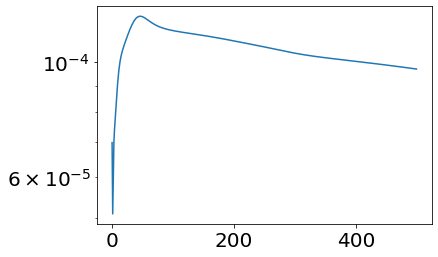

<Figure size 432x288 with 0 Axes>

In [29]:
# -------
# create model and define criterion and optimizer
# -------
module_load = False
save = True

# note specify load path
if module_load:
    load_PATH = '/home/qh8373/UCRB/0507_grande'
    with open(load_PATH+'/params.txt') as f:
        lines = f.readlines()
        print('model parameter description \n', lines, '\n')
        
    num_classes = int(lines[-1][-4:-1].replace('=',''))
    num_layers = int(lines[-2][-4:-1].replace('=',''))
    hidden_size = int(lines[-3][-4:-1].replace('=',''))
    input_size = int(lines[-4][-4:-1].replace('=',''))
    seq_length = int(lines[-9][-3:-1].replace('h',''))
#     print(num_classes, num_layers, hidden_size, input_size, seq_length)
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)
    lstm.load_state_dict(torch.load(load_PATH+'/model.txt'))
else:
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length) # , seq_length)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) # Adam as optimizer

epoch_array = []
loss_array = []

# Train the model
for epoch in range(num_epochs):
    for xb, xy in train_dl:
        
        # make predictions
        outputs = lstm(xb)
        
#         print('outputs shape ', outputs.shape)
#         print('target shape ', xy.shape)

#         print(torch.isnan(xy))
        
        # obtain the loss function
        loss = criterion(outputs, xy)

        # back propogation
        loss.backward()

        # update the weights backward
        optimizer.step()
        
        # zero gradients
        optimizer.zero_grad()

#     # print results of fitting if epochal condition is met
#     if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    epoch_array.append(epoch)
    loss_array.append(loss.item())

print('')
print('the relationship between loss and epochs for given hyper parameters')
plt.plot(epoch_array, loss_array)
plt.yscale('log')
plt.show()
if save:
    plt.savefig(path+'/epochs.png')
    # save epoch file
    file = open(path+"/epochs.txt", "w")
    file.write(str(epoch_array))
    file.close()
    # save loss array file
    file = open(path+"/loss.txt", "w")
    file.write(str(loss_array))
    file.close()
    # save model
    torch.save(lstm.state_dict(), path+'/model.txt')

## Score the LSTM, Compare to Reality, and save results
* This portion reflects the score and fit of the autoregression when compared to reality 

In [48]:
def recon_Y(t_bool,y_in):
    '''
    A sub for reconstructing time series of Y
    '''
    
#     print(t_bool.shape)
#     print(y_in[0,0])
#     print(y_in.shape)
    y_out = np.empty((t_bool.shape[0],1))
#     print(y_out.shape)
    
    it = 0
    for idx in range(t_bool.shape[0]):
#         print(idx)
        if t_bool[idx]:
            y_out[idx,0] = np.nan
        else:
            y_out[idx,0] = y_in[it, 0]
            it = it + 1
        
#     print(y_out)
    
    return y_out


model parameter description 
 ['Run Datetime 2021-05-07 14:14:41.798293\n', 'Sample Date Range 1987 to 2005\n', 'Huc index: 0\n', 'Huc Name: 9110000\n', 'Sequence Length 14\n', 'Prediction Length 7\n', 'test fraction 0.2\n', 'LSTM Params: Number of epochs - 500\n', 'LSTM Params: learning rate - 0.001\n', 'LSTM Params: input_size = 9\n', 'LSTM Params: hidden_size = 10\n', 'LSTM Params: num_layers = 1\n', 'LSTM Params: num_classes = 1\n'] 

The R-squared value for LSTM is  0.8145465052194059
RMSE      |        NSE       |            KGE 
 [0.10271243 0.8145465  0.81494547]
The R-squared value for LSTM < 10% flow is  -32.80976770005311
RMSE      |        NSE       |            KGE 
 [  0.03757775 -32.80976105  -1.1199542 ]
The R-squared value for LSTM > 90% flow is  -0.7409377982907885
RMSE      |        NSE       |            KGE 
 [ 0.09780248 -0.74093747  0.04591805]
The R-squared value for LSTM is  0.7125183426929422
RMSE      |        NSE       |            KGE 
 [0.05040575 0.712518

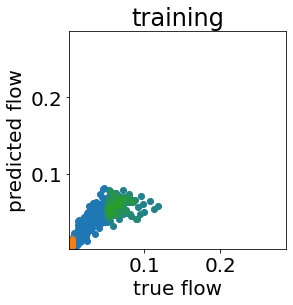

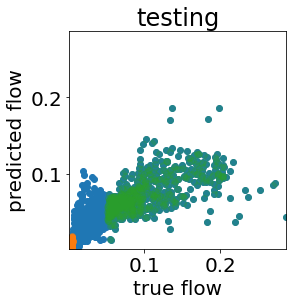

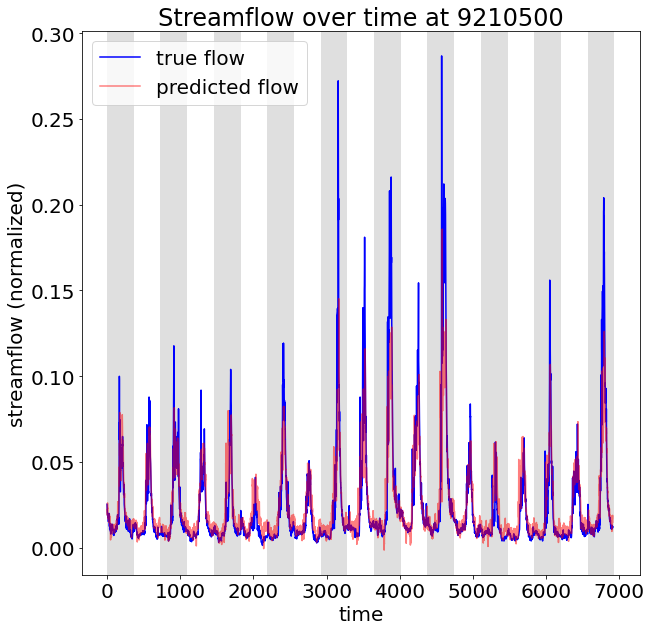

In [53]:
module_load = True
save = True

# note specify load path
if module_load:
    load_PATH = '/home/qh8373/UCRB/0507_grande'
    with open(load_PATH+'/params.txt') as f:
        lines = f.readlines()
        print('model parameter description \n', lines, '\n')
        
    num_classes = int(lines[-1][-4:-1].replace('=',''))
    num_layers = int(lines[-2][-4:-1].replace('=',''))
    hidden_size = int(lines[-3][-4:-1].replace('=',''))
    input_size = int(lines[-4][-4:-1].replace('=',''))
    seq_length = int(lines[-9][-3:-1].replace('h',''))
#     print(num_classes, num_layers, hidden_size, input_size, seq_length)
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)
    lstm.load_state_dict(torch.load(load_PATH+'/model.txt'))


# explicitly tell the model we are evaluating it now
lstm.eval()

# make a prediction using the model on all of the data
data_predict = lstm(trainX)

# convert to numpy array
data_predict = data_predict.data.numpy()
dataY_plot = trainY.data.numpy()

# create a mask just in case
data_predict = ma.masked_invalid(data_predict)
dataY_plot = ma.masked_invalid(dataY_plot)

# score the LSTM
r2_train = r2_score(dataY_plot[(dataY_plot.mask==False) & (data_predict.mask==False)],
      data_predict[(dataY_plot.mask==False) & (data_predict.mask==False)])

stats_train = compute_stats(dataY_plot[(dataY_plot.mask==False) & (data_predict.mask==False)],
      data_predict[(dataY_plot.mask==False) & (data_predict.mask==False)])

print('The R-squared value for LSTM is ', r2_train) 

print('RMSE      |        NSE       |            KGE','\n', stats_train)


# score the LSTM on low flow

cond1 = (dataY_plot.mask==False) & (data_predict.mask==False) & (dataY_plot.data < perc_10_arr[0,huc_index])

r2_train_low = r2_score(dataY_plot[cond1], data_predict[cond1])
stats_train_low = compute_stats(dataY_plot[cond1], data_predict[cond1])

print('The R-squared value for LSTM < 10% flow is ', r2_train_low) 

print('RMSE      |        NSE       |            KGE','\n', stats_train_low)


# score the LSTM on high flow

cond2 = (dataY_plot.mask==False) & (data_predict.mask==False) & (dataY_plot.data > perc_10_arr[1,huc_index])

r2_train_hi = r2_score(dataY_plot[cond2], data_predict[cond2])
stats_train_hi = compute_stats(dataY_plot[cond2], data_predict[cond2])

print('The R-squared value for LSTM > 90% flow is ', r2_train_hi) 

print('RMSE      |        NSE       |            KGE','\n', stats_train_hi)


plt.rcParams.update({'font.size': 20})

# plot 
fig, ax = plt.subplots()
plt.scatter(dataY_plot, data_predict)
plt.scatter(dataY_plot[cond1], data_predict[cond1], alpha=0.25)
plt.scatter(dataY_plot[cond2], data_predict[cond2], alpha=0.25)
ax.set_xlim(perc_10_arr[2, huc_index],perc_10_arr[3, huc_index])
ax.set_ylim(perc_10_arr[2, huc_index],perc_10_arr[3, huc_index])
ax.set_xlabel('true flow')
ax.set_ylabel('predicted flow')
# ax.set_xlim(0, 1.0)
# ax.set_ylim(0, 1.0)
ax.set_aspect('equal')
plt.title('training')
fig.show()
if save:
    if module_load:
        path_out = load_PATH+'/'+str(huc_name_list[huc_index])+'_test'
        try:
            os.mkdir(path_out)
        except:
            print('warning: file exists')
            pass
    else:
        path_out = path
    fig.savefig(path_out+'/training.png')
    file = open(path_out+"/score_train.txt", "w")
    file.write(str(r2_train) + '\n' + str(stats_train) + str(r2_train_low) + '\n' + str(stats_train_low) + '\n' + str(r2_train_hi) + '\n' + str(stats_train_hi))
    file.close()


# # make a prediction using the model on all of the data
data_predict_test = lstm(testX)

# convert to numpy array
data_predict_test = data_predict_test.data.numpy()
dataY_plot_test = testY.data.numpy()

# create a mask just in case
data_predict_test = ma.masked_invalid(data_predict_test)
dataY_plot_test = ma.masked_invalid(dataY_plot_test)

# score the LSTM
r2_test = r2_score(dataY_plot_test[(dataY_plot_test.mask==False) & (data_predict_test.mask==False)],
               data_predict_test[(dataY_plot_test.mask==False) & (data_predict_test.mask==False)])

stats_test = compute_stats(dataY_plot_test[(dataY_plot_test.mask==False) & (data_predict_test.mask==False)],
        data_predict_test[(dataY_plot_test.mask==False) & (data_predict_test.mask==False)])

print('The R-squared value for LSTM is ', r2_test)

print('RMSE      |        NSE       |            KGE','\n', stats_test)


# score the LSTM on low flow
cond1 = (dataY_plot_test.mask==False) & (data_predict_test.mask==False) & (dataY_plot_test.data < perc_10_arr[0,huc_index])

r2_test_low = r2_score(dataY_plot_test[cond1], data_predict_test[cond1])
stats_test_low = compute_stats(dataY_plot_test[cond1], data_predict_test[cond1])

print('The R-squared value for LSTM < 10% flow is ', r2_test_low) 

print('RMSE      |        NSE       |            KGE','\n', stats_test_low)

# score the LSTM on high flow
cond2 = (dataY_plot_test.mask==False) & (data_predict_test.mask==False) & (dataY_plot_test.data > perc_10_arr[1,huc_index])

r2_test_hi = r2_score(dataY_plot_test[cond2],data_predict_test[cond2])
stats_test_hi = compute_stats(dataY_plot_test[cond2],data_predict_test[cond2])
                        
print('The R-squared value for LSTM > 90% flow is ', r2_test_hi) 

print('RMSE      |        NSE       |            KGE','\n', stats_test_hi)

# plot 
fig, ax = plt.subplots()
plt.scatter(dataY_plot_test, data_predict_test)
plt.scatter(dataY_plot_test[cond1], data_predict_test[cond1], alpha=0.25)
plt.scatter(dataY_plot_test[cond2], data_predict_test[cond2], alpha=0.25)
ax.set_xlim(perc_10_arr[2, huc_index],perc_10_arr[3, huc_index])
ax.set_ylim(perc_10_arr[2, huc_index],perc_10_arr[3, huc_index])
ax.set_xlabel('true flow')
ax.set_ylabel('predicted flow')
# ax.set_xlim(0, 1.0)
# ax.set_ylim(0, 1.0)
ax.set_aspect('equal')
plt.title('testing')
fig.show()
if save:
    if module_load:
        path_out = load_PATH+'/'+str(huc_name_list[huc_index])+'_test'
    else:
        path_out = path
    fig.savefig(path_out+'/testing.png')
    file = open(path_out+"/score_test.txt", "w")
    file.write(str(r2_test) + ' ' + str(stats_test) + '\n' + str(r2_test_low) + ' ' + str(stats_test_low) + '\n' + str(r2_test_hi) + ' ' + str(stats_test_hi))
    file.close()
    
# data for plotting
dataY_plot = dataY.data.numpy()
print(dataY_plot.shape)
dataY_plot = recon_Y(t_bool,dataY_plot)
dataY_plot = ma.masked_invalid(dataY_plot)

predY_plot = lstm(dataX).data.numpy()
predY_plot = recon_Y(t_bool,predY_plot)
predY_plot = ma.masked_invalid(predY_plot)

# defaults of labelist ['DLWR', 'DSWR', 'Press', 'APCP', 'Temp', 'SPFH', 'UGRD', 'VGRD', 'Flow_Real']

label_dex = 4
inputX_1 = np.expand_dims(np.mean(dataX.data.numpy()[:,:,label_dex], axis = 1) , axis=1)
print(inputX_1.shape)
inputX_1 = recon_Y(t_bool,inputX_1)
inputX_1 = ma.masked_invalid(inputX_1)
    

# general plots comparing predicted streamflow over prediction interval
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(range(dataY_plot.shape[0]), dataY_plot, color='blue', label='true flow')
# ax.plot(range(data_predict.shape[0],data_predict.shape[0]+data_predict_test.shape[0]), data_predict_test, color='green', label='test flow model', alpha=0.5)
# ax.plot(range(data_predict.shape[0]), data_predict, color='red', label='train flow model', alpha=0.5)
ax.plot(range(predY_plot.shape[0]), predY_plot, color='red', label='predicted flow', alpha=0.5)
# ax.plot(range(inputX_1.shape[0]), inputX_1, color='green', label=labelist[label_dex], alpha=0.5)
ax.set_xlabel('time')
ax.set_ylabel('streamflow (normalized)')
ax.set_title('Streamflow over time at '+str(huc_name_list[huc_index]))
plt.legend(loc=0)
for i in range(0,len(YEARS),2):
    day = i*365
    plt.axvspan(day,day+365, facecolor='grey', alpha=0.25)
fig.show()
if save:
    if module_load:
        path_out = load_PATH+'/'+str(huc_name_list[huc_index])+'_test'
    else:
        path_out = path
    fig.savefig(path_out+'/flow_comp.png')
    



### Generate Statistics to Evaluate Model Transferability and Performance

    Approach  ID  Train domain  Test domain Model Name Test Statistics  \
0          1   1       9110000      9110000     0506_b  All Streamflow   
1          1   1       9110000      9110000     0506_b  10% Exceedence   
2          1   1       9110000      9110000     0506_b  90% Exceedence   
3          1   2       9329050      9329050     0506_e  All Streamflow   
4          1   2       9329050      9329050     0506_e  10% Exceedence   
..       ...  ..           ...          ...        ...             ...   
70         2  24       9196500      9210500     0506_f  10% Exceedence   
71         2  24       9196500      9210500     0506_f  90% Exceedence   
72         2  25       9107000      9210500     0506_g  All Streamflow   
73         2  25       9107000      9210500     0506_g  10% Exceedence   
74         2  25       9107000      9210500     0506_g  90% Exceedence   

         R_2    RMSD       NSE      KGE  Unnamed: 10  Unnamed: 11  
0     0.8385  0.9466    0.8385   0.7466    

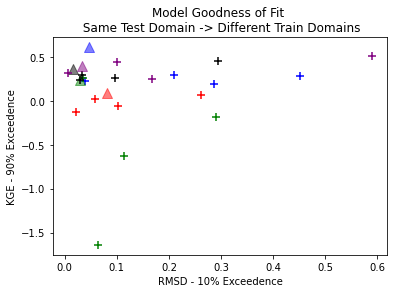

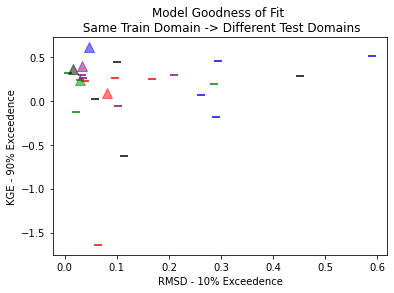

In [47]:
# Load Data
MP_simp = pd.read_csv('Mainplot_simple_statistics.csv')
print(MP_simp)

# set upconditions
cond_10 = (MP_simp['Test Statistics'] == '10% Exceedence')
cond_90 = (MP_simp['Test Statistics'] == '90% Exceedence')
cond_1 = (MP_simp['Approach'] == 1)
cond_2 = (MP_simp['Approach'] == 2)

collist = ['blue','green','red', 'black', 'purple'] #  'purple', 'indigo','black']
marker_list = ['^', '+']

print(huc_name_list)

# set up colors
i = 0
for huc in huc_name_list:
    # plot approach 1
    cond_huc = (MP_simp['Test domain'] == huc)
    plt.scatter(MP_simp['RMSD'][cond_10 & cond_1 & cond_huc], MP_simp['KGE'][cond_90 & cond_1 & cond_huc], alpha=0.5, s=100, marker=marker_list[0], color=collist[i])
    plt.scatter(MP_simp['RMSD'][cond_10 & cond_2 & cond_huc], MP_simp['KGE'][cond_90 & cond_2 & cond_huc], s=75, marker=marker_list[1], color=collist[i])
    #     plt.scatter(MP_simp['RMSD'](cond_10 & cond_1 & (MP_simp['Test domain'] == huc)), marker=marker_list[0], color=collist[i])
#     plt.scatter(MP_simp['KGE'](cond_90 & cond_2 & (MP_simp['Test domain'] == huc)), marker=marker_list[1], color=collist[i])
    i = i + 1
    
plt.title('Model Goodness of Fit \n Same Test Domain -> Different Train Domains')
plt.xlabel('RMSD - 10% Exceedence')
plt.ylabel('KGE - 90% Exceedence')
plt.show()

collist = ['blue','green','red', 'black', 'purple'] #  'purple', 'indigo','black']
marker_list = ['^', '_']
# set up colors
i = 0
for huc in huc_name_list:
    # plot approach 1
    cond_huc = (MP_simp['Train domain'] == huc)
    plt.scatter(MP_simp['RMSD'][cond_10 & cond_1 & cond_huc], MP_simp['KGE'][cond_90 & cond_1 & cond_huc], alpha=0.5, s=100, marker=marker_list[0], color=collist[i])
    plt.scatter(MP_simp['RMSD'][cond_10 & cond_2 & cond_huc], MP_simp['KGE'][cond_90 & cond_2 & cond_huc], s=75, marker=marker_list[1], color=collist[i])
    #     plt.scatter(MP_simp['RMSD'](cond_10 & cond_1 & (MP_simp['Test domain'] == huc)), marker=marker_list[0], color=collist[i])
#     plt.scatter(MP_simp['KGE'](cond_90 & cond_2 & (MP_simp['Test domain'] == huc)), marker=marker_list[1], color=collist[i])
    i = i + 1
    
plt.title('Model Goodness of Fit \n Same Train Domain -> Different Test Domains')
plt.xlabel('RMSD - 10% Exceedence')
plt.ylabel('KGE - 90% Exceedence')
plt.show()
    

    
